# Deploy SDXL to SageMaker for inference with DJL-LMI DLC

* Example demonstrates how to deploy SDXL base+refiner models with LoRA on SageMaker
* You can deploy other customized SDXL model rather than base model without compressing model by using "serving.properties.option.s3url" parameter instead of "option.model_id"
* Inference DLC uses [Large Model Inference Containers - djl-inference:0.23.0](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers) container
* Inference endpoint instance uses ml.g5.2xlarge 
* Regarding more details about how to customize DJL-LMI inference, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-tutorials-fastertransformer.html)

## 1. Initialize SageMaker

In [ ]:
!pip install --upgrade boto3 sagemaker huggingface_hub

In [ ]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session._region_name
account_id = sagemaker_session.account_id()
# sagemaker_client = boto3.client('sagemaker')

## 2. Customize deployment files for DJL-LMI DLC

In [3]:
!mkdir -p ./deploycode

In [ ]:
%%writefile ./deploycode/requirements.txt
boto3
diffusers>=0.19.3
invisible_watermark

In [ ]:
%%writefile ./deploycode/model.py
import logging
import time
import base64
import torch
import boto3
import json
import os

from djl_python import Input, Output
from botocore.exceptions import ClientError
from io import BytesIO
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

# Solve import cv2 with missing "libGL.so.1" issue
os.system("ln -s /opt/nvidia/nsight-compute/2022.3.0/host/linux-desktop-glibc_2_11_3-x64/Mesa/libGL.so.1 /usr/lib/libGL.so.1")

s3 = boto3.client('s3')

def check_file_existence(s3_path):
    bucket_name = s3_path.split("//")[1].split("/")[0]
    object_key = "/".join(s3_path.split("//")[1].split("/")[1:])
    try:
        s3.head_object(Bucket=bucket_name, Key=object_key)
        return True
    except ClientError as e:
        if e.response['Error']['Code'] == '404':
            return False
        else:
            raise

def download_file(s3_path):
    file_path = os.path.join("/tmp/", os.path.basename(s3_path))
    if os.path.exists(file_path):
        print("LoRA file already exists locally. Skipping download.")
        return file_path
    if check_file_existence(s3_path):
        bucket_name = s3_path.split("//")[1].split("/")[0]
        object_key = "/".join(s3_path.split("//")[1].split("/")[1:])
        s3.download_file(bucket_name, object_key, file_path)
        return file_path
    else:
        raise ValueError('LoRA file does not exist. Upload files to S3 first!')
        
def encode_image(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    encoded_image_response = base64.b64encode(buffered.getvalue()).decode()
    return encoded_image_response
        
        
def load_model(properties):
    model_location = properties['model_dir']
    if "model_id" in properties:
        model_location = properties['model_id']
    logging.info(f"Loading model in {model_location}")
    base_pipe = DiffusionPipeline.from_pretrained(
        model_location,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        cache_dir="/tmp/",
    ).to("cuda")
    # Refering to https://github.com/huggingface/diffusers/issues/2905, implemented “DPM++ 2M Karras” scheduler here
    base_pipe.scheduler = DPMSolverMultistepScheduler.from_config(
        base_pipe.scheduler.config, 
        use_karras_sigmas=True
    )
    # Default to load refiner model in advance
    refiner_model = 'stabilityai/stable-diffusion-xl-refiner-1.0'
    refiner_pipe = DiffusionPipeline.from_pretrained(
                refiner_model,
                text_encoder_2=base_pipe.text_encoder_2,
                vae=base_pipe.vae,
                torch_dtype=torch.float16,
                use_safetensors=True,
                variant="fp16",
                cache_dir="/tmp/",
            ).to("cuda")
    return base_pipe, refiner_pipe

base_pipe = None
refiner_pipe = None

def handle(inputs: Input):
    global base_pipe, refiner_pipe
    if not base_pipe:
        base_pipe, refiner_pipe = load_model(inputs.get_properties())
    if inputs.is_empty():
        return None
    data = inputs.get_as_json()
    generator = torch.Generator(device="cuda")
    use_refiner = data.pop("refiner", "")
    high_noise_frac = data.pop("high_noise_frac", 0.8)
    prompt = data.pop("prompt", "")
    negative_prompt = data.pop("negative_prompt", "")
    height = data.pop("height", 1024)
    width = data.pop("width", 1024)
    num_inference_steps = data.pop("num_inference_steps", 20)
    guidance_scale = data.pop("guidance_scale", 7)
    num_images_per_prompt = data.pop("num_images_per_prompt", 2)
    seed = data.pop("seed", "")
    lora_s3_path = data.pop("lora_s3_path", "")
    
    seeds = []
    encoded_images = []

    if seed:
        seeds = [seed + i for i in range(num_images_per_prompt)]
    else:
        seeds = [generator.seed() for _ in range(num_images_per_prompt)]

    for current_seed in seeds:
        generator.manual_seed(current_seed)
        base_pipe = base_pipe
        if lora_s3_path:
            lora_weight_path = download_file(lora_s3_path)
            base_pipe.load_lora_weights(lora_weight_path, low_cpu_mem_usage=True)
        else:
            base_pipe.unload_lora_weights()
        if use_refiner == "enable":
            notification = "SDXL refiner model is enabled!" 
            start_time = time.time()
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                denoising_end=high_noise_frac,
                generator=generator,
                output_type="latent",
            ).images
            generated_images = refiner_pipe(
                prompt=prompt,
                num_inference_steps=num_inference_steps,
                denoising_start=high_noise_frac,
                image=generated_images,
            ).images[0]
            end_time = time.time()
            execution_time = end_time - start_time
            print("Time for precessing images:", execution_time, "s")
        else:
            notification = "SDXL refiner model is disabled!"
            start_time = time.time()
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator
            ).images[0]
            end_time = time.time()
            execution_time = end_time - start_time
            print("Time for precessing images:", execution_time, "s")  
            
        encoded_image_rt = encode_image(generated_images)
        encoded_images.append(encoded_image_rt)
        
    results = {"notification": notification, "generated_images": encoded_images, "seeds": seeds}
    return Output().add_as_json(results)

In [ ]:
%%writefile ./deploycode/serving.properties
engine=Python
option.model_id=stabilityai/stable-diffusion-xl-base-1.0
# option.s3url = s3://abc/xyz  # You can comment out "model_id" and uncomment "s3url" to deploy other customized SDXL model rather than base model with no need to compress model

## 3. Package deployment files and upload to S3

In [7]:
import tarfile
import os

folder_path = './deploycode'
output_filename = 'deploycode.tar.gz'

with tarfile.open(output_filename, "w:gz") as tar:
    tar.add(folder_path, arcname=os.path.basename(folder_path))

In [ ]:
s3_code_prefix = 'deploycode'
s3_code_artifact = sagemaker_session.upload_data("deploycode.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

## 4. Dowload LoRA weight and upload to S3

In [ ]:
from huggingface_hub import snapshot_download
from sagemaker.s3 import S3Uploader

# Supposed you download LoRaA from HF.
local_dir = './model'
snapshot_download(
    repo_id="terrificdm/immature-lora", # We used a self-trained LoRA as a example 
    allow_patterns="*.safetensors",
    local_dir=local_dir,
    local_dir_use_symlinks=False)

# Upload LoRA weight which you want to deploy to S3.
s3_model_uri=S3Uploader.upload(local_path='./model', desired_s3_uri=f"s3://{bucket}/lora-model") + '/'
lora_s3_path=s3_model_uri+'immature-lora.safetensors'
print("\nYour LoRA model and deployment scripts are located in s3_model_uri =", s3_model_uri)
print("\nYour LoRA model s3 path is lora_s3_path =", lora_s3_path)

## 5. Create and deploy model

In [10]:
from sagemaker import image_uris

inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed",
    region=region,
    version="0.23.0",
)

In [11]:
from sagemaker.model import Model

def create_model(model_name, model_s3_url):   
    model = Model(
        image_uri=inference_image_uri,
        model_data=model_s3_url,
        role=role,
        name=model_name,
        sagemaker_session=sagemaker_session,
    )
    return model

In [12]:
from sagemaker import serializers, deserializers

def deploy_model(model, _endpoint_name):
    model.deploy(
        initial_instance_count=1,
        instance_type="ml.g5.2xlarge",
        endpoint_name=_endpoint_name
    )
    predictor = sagemaker.Predictor(
        endpoint_name=_endpoint_name,
        sagemaker_session=sagemaker_session,
        serializer=serializers.JSONSerializer(),
        deserializer=deserializers.JSONDeserializer()
    )
    return predictor

In [ ]:
from sagemaker.utils import name_from_base

_model_name = name_from_base(f"sdxl") # Append a timestamp to the provided string
_model_s3_url = s3_code_artifact
_endpoint_name = f"{_model_name}-endpoint"

model = create_model(_model_name, _model_s3_url)
predictor = deploy_model(model, _endpoint_name)

## 6. Inference test

In [14]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)


Notification: SDXL refiner model is enabled!



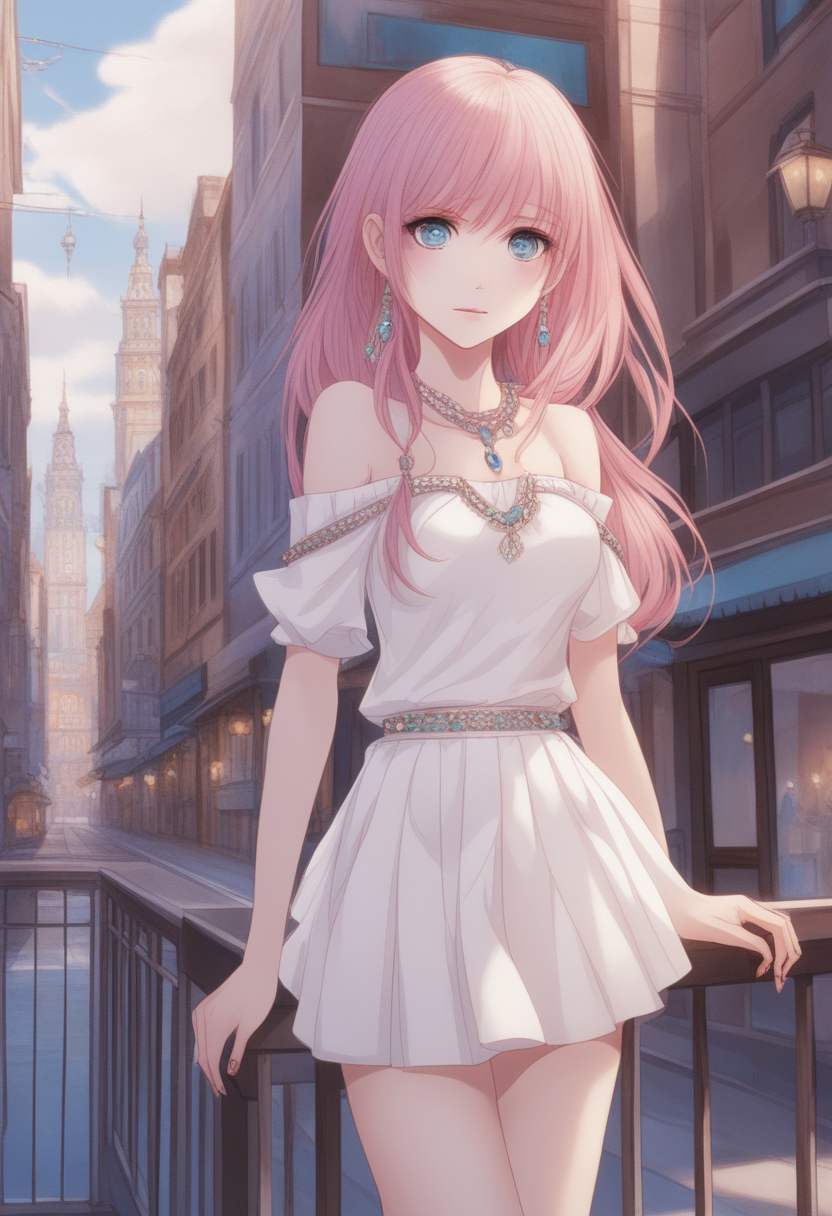


Seeds for generating images: [1277460555321081]


In [17]:
# run prediction
response = predictor.predict(data={
    "prompt": "1girl, standing, blue eyes, parted lips, long hair, pink hair, bangs, jewelry, bare shoulder, skirt, beautiful legs, white shoes, looking at viewer, full body, solo, city background",
    "negative_prompt": "ugly, disfigured, distorted body, bad hands",
    "height": 1216,
    "width": 832,
    "num_images_per_prompt": 1,
    "refiner": "enable",
    "num_inference_steps": 30,
    "high_noise_frac": 0.8,
    "guidance_scale": 7.5,
    "lora_s3_path": lora_s3_path, # You can change s3 url of the lora model in dynamic
    # "seed" : 2243221490029453  # uncomment seed and replace with generated one, if you want to produce same
  }
)

print(f"\nNotification: {response['notification']}\n")

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    
# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")